In [104]:
import os
import requests
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from langchain_core.prompts import PromptTemplate



In [105]:
load_dotenv()
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
LINKEDIN_ACCESS_TOKEN = os.getenv("LINKEDIN_ACCESS_TOKEN")
OWNER = "urn:li:person:5ko67kWFyU"

#Testing HuggingFace_Token

In [106]:
prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      

      Question: {question}
    """,
    input_variables = ['question']
)

question= "What is the capital of France?"
final_prompt = prompt.invoke({"question": question}).to_string()
print(final_prompt)


      You are a helpful assistant.


      Question: What is the capital of France?
    


In [107]:

client = InferenceClient()
llm="meta-llama/Llama-3.1-8B-Instruct"
completion = client.chat.completions.create(
    model=llm,
    messages=[
        {"role": "user", "content": final_prompt}
    ]
)

print(completion.choices[0].message.content)

The capital of France is Paris. I'm here to help, is there anything else you need to know?


Agent Implementation

In [108]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional

Define Agent State Variables

In [109]:
# define state
class JD_State(TypedDict):

    JD_Description: str
    JD: str
    approved: Optional[bool]
    feedback: Optional[str]
    linkedin_posted: bool
    linkedin_post_urn: str | None

Define Nodes

In [110]:
def generate_JD(state: JD_State) -> JD_State:
    
    JD_Description=state["JD_Description"]
    feedback = state.get("feedback")
    
    prompt = PromptTemplate(
    template="""
      You are a helpful assistant who can create a Job description based on the given requirements and feedback.
      

      Requirements: {JD_Description}
      Feedback_For_Previous_Generated_JD: {feedback}
    """,
    input_variables = ['JD_Description','feedback']
    )

    
    final_prompt = prompt.invoke({
        "JD_Description": JD_Description, 
        "feedback": feedback or "No previous feedback"
        }).to_string()
    
    client = InferenceClient()
    llm="meta-llama/Llama-3.1-8B-Instruct"
    completion = client.chat.completions.create(
        model=llm,
        messages=[
            {"role": "user", "content": final_prompt}
        ]
    )

    jd_content=completion.choices[0].message.content
    if not jd_content:
        raise RuntimeError("LLM returned empty JD")

    state["JD"]=jd_content
    state["approved"] = None
    
    return state

In [111]:
def post_jd_to_linkedin(state: JD_State) -> JD_State:
    
    load_dotenv()

    LINKEDIN_ACCESS_TOKEN = os.getenv("LINKEDIN_ACCESS_TOKEN")
    OWNER = "urn:li:person:5ko67kWFyU"
    
    # Prevent duplicate posting
    if state.get("linkedin_posted"):
        print("⚠️ JD already posted to LinkedIn. Skipping.")
        return state

    jd_text = state.get("JD")
    if not jd_text:
        raise ValueError("JD is empty. Cannot post.")

    url = "https://api.linkedin.com/v2/ugcPosts"

    headers = {
        "Authorization": f"Bearer {LINKEDIN_ACCESS_TOKEN}",
        "X-Restli-Protocol-Version": "2.0.0",
        "Content-Type": "application/json"
    }

    post_data = {
        "author": OWNER,
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": {
                    "text": jd_text
                },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    response = requests.post(url, headers=headers, json=post_data)

    # ❌ Failure → do NOT mark as posted
    if response.status_code not in (200, 201):
        raise RuntimeError(
            f"LinkedIn post failed: {response.status_code} - {response.text}"
        )

    response_data = response.json()

    # ✅ LinkedIn returns the post URN
    post_urn = response_data.get("id")

    if not post_urn:
        raise RuntimeError("Post created but no URN returned by LinkedIn")

    print("✅ JD successfully posted to LinkedIn")
    print("🔗 Post URN:", post_urn)

    # ✅ Update state = VERIFIED
    state["linkedin_posted"] = True
    state["linkedin_post_urn"] = post_urn

    return state

In [112]:
def test_post_jd_to_linkedin(state: JD_State) -> JD_State:
    
    print("✅ JD successfully posted to LinkedIn")
    state["linkedin_posted"] = True
    
    return state

In [113]:
from langgraph.types import interrupt

def human_review(state: JD_State) -> JD_State:
    decision = interrupt({
        "JD": state["JD"],
        "message": "Approve or reject the JD",
    })
    
    state["approved"] = decision.get("approved", False)
    
    state["feedback"] = decision.get("feedback", "")
    
    return state



In [114]:
def approval_router(state: JD_State) -> str:
    if state["approved"] is True:
        return "test_post_jd_to_linkedin"
    else:
        return "generate_JD"


Define your Agentic Workflow

In [115]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
graph = StateGraph(JD_State)

graph.add_node("generate_JD", generate_JD)
graph.add_node("human_review", human_review)
graph.add_node("test_post_jd_to_linkedin", test_post_jd_to_linkedin)

graph.set_entry_point("generate_JD")

graph.add_edge("generate_JD", "human_review")

graph.add_conditional_edges(
    "human_review",
    approval_router,
    {
        "test_post_jd_to_linkedin": "test_post_jd_to_linkedin",
        "generate_JD": "generate_JD"
    }
)

graph.add_edge("test_post_jd_to_linkedin", END)





In [121]:
from langgraph.checkpoint.memory import InMemorySaver

workflow = graph.compile(
    checkpointer=InMemorySaver()
)

In [122]:
config = {"configurable": {"thread_id": "jd_approval_1"}}

paused = workflow.invoke(
    {"JD_Description": "5+ years required, keep it less than 25 words"},
    config=config
)

print(paused["__interrupt__"])

[Interrupt(value={'JD': 'Here is the Job Description:\n\n**Senior Software Engineer**\nDesign, develop, and maintain scalable software applications with 5+ years of experience in coding languages, integrating systems.', 'message': 'Approve or reject the JD'}, id='6dff47e86af56203ac259218ffe02abe')]


In [123]:
from langgraph.types import Command

final = workflow.invoke(
    Command(resume={"approved": False,"feedback": "Change the experience to 10 years"}),
    config=config
)

print(final)

{'JD_Description': '5+ years required, keep it less than 25 words', 'JD': 'Here is a revised job description:\n\n**Job Title: Senior [Role]**\n\n10+ years of experience in [industry/field] required; lead a team implementing strategic initiatives with proven track record of success.', 'approved': None, 'feedback': 'Change the experience to 10 years', '__interrupt__': [Interrupt(value={'JD': 'Here is a revised job description:\n\n**Job Title: Senior [Role]**\n\n10+ years of experience in [industry/field] required; lead a team implementing strategic initiatives with proven track record of success.', 'message': 'Approve or reject the JD'}, id='16c2673357e8bb70409aae8d0528d50a')]}


In [119]:
from langgraph.types import Command

final = workflow.invoke(
    Command(resume={"approved": True}),
    config=config
)

print(final)


✅ JD successfully posted to LinkedIn
{'JD_Description': '5+ years required, keep it less than 25 words', 'JD': 'Here is a job description based on the requirements:\n\n**Job Title: Senior Operations Manager (India)**\n\nLead operations across India, leveraging 5+ years of experience to drive growth and efficiency.', 'approved': True, 'feedback': '', 'linkedin_posted': True}


Visuvalize your workflow

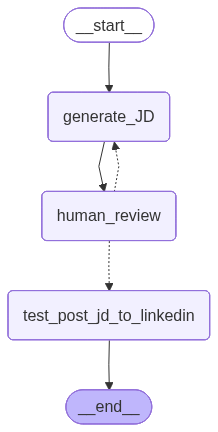

In [120]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())